# Table of contents
1. [Introduction](#introduction)
2. [YOLO Evaluation](#yoloevaluation)
    1. [Load OIDv6](#yololoadoid)
    2. [Merge labels into one](#yolomergelabels)
    3. [Load YOLOv5 dataset](#yololoadv5)
    4. [Perform detections](#yoloperformdetections)
    5. [Evaluate detections](#yolodetectionseval)
    6. [Calculate results and plot them](#yoloshowresults)
    7. [View dataset in fiftyone](#yolofiftyonesession)

## Introduction <a name="introduction"></a>

This notebook loads the test dataset in YOLOv5 format from disk and evaluates the object detection model's performance.

In [1]:
import fiftyone as fo
from PIL import Image
from detection import detect
from detection import detect_yolo_only

/home/zenon/.local/share/miniconda3/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## YOLO Model Evaluation <a name="yoloevaluation"></a>

In this section we look at the object detection model in detail by evaluating it separately from the classification model. The object detection model was trained on the Open Images Dataset v6 on the two classes _Plant_ and _Houseplant_ which come with the dataset. 

### Load OIDv6 <a name="yololoadoid"></a>

Since we are only interested in evaluating the model, we only load the _test_ split of the dataset. The only classes of interest to us are _Plant_ and _Houseplant_ and we do not want to load keypoint detections or segmentation masks, which is why we specify the `label_types` parameter. There are 9148 images in the test split.

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
oid = foz.load_zoo_dataset(
    "open-images-v6",
    split="test",
    classes=["Plant", "Houseplant"],
    label_types=["detections"],
    shuffle=True,
)

Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading 'open-images-v6' split 'test'
 100% |█████████████| 12106/12106 [1.0m elapsed, 0s remaining, 209.3 samples/s]      
Dataset 'open-images-v6-test' created


### Export dataset for conversion <a name="yoloexportoid"></a>

Unfortunately, the OID dataset does not adhere to the YOLOv5 label format understood by the object detection model. That is why we export the model as a YOLOv5Dataset using fiftyone's converter. The target directory will contain the proper folder structure as well as a `.yaml` file pointing to the images and labels. Take note that the exported files require around 4.2G of space.

In [25]:
# The directory to which to write the exported dataset
import os

export_dir = "/home/zenon/testdir"

# Only export if export_dir doesn't exist already
if not os.path.isdir(export_dir):
    # The name of the sample field containing the label that you wish to export
    # Used when exporting labeled datasets (e.g., classification or detection)
    label_field = "detections"  # for example

    # The type of dataset to export
    # Any subclass of `fiftyone.types.Dataset` is supported
    dataset_type = fo.types.YOLOv5Dataset  # for example

    # Export the dataset
    oid.export(
        export_dir=export_dir,
        dataset_type=dataset_type,
        label_field=label_field,
        classes=['Plant', 'Houseplant']
    )

### Merge labels into one <a name="yolomergelabels"></a>

The label files contain a 0 at the beginning of each line if the ground truth specifies a plant and a 1 if it specifies a houseplant. We do not care about the distinction between the two and only want to detect plants in general. That means we have to change all 1s at the beginning of each line in each label file into 0s. The YOLOv5 format requires that the labels start at 0 and not at 1, which is why 1s are changed to 0s and not vice-versa. To accomplish this task, we use a simple bash script in the labels directory:
```bash
for file in `ls test`
do
    sed -i 's/^./0/g' test/$file
done
```
This script calls sed to change the first character in each file to a 0. It performs the conversion in place (`-i` flag). For this script to work, the `val` directories inside `images` and `labels` must be renamed to `test` and the path to the directory changed in the `data.yaml` file. I believe `val` is the wrong name for a test dataset and it should be named accordingly.

### Load YOLOv5 dataset <a name="yololoadv5"></a>

Now that the labels are in the correct format and we only have one class to deal with, we can import the dataset into the variable `yolo`.

In [ ]:
yolo_dataset_dir = '/home/zenon/testdir'

# The type of the dataset being imported
dataset_type = fo.types.YOLOv5Dataset

# Import the dataset
yolo_test = fo.Dataset.from_dir(
    dataset_dir=yolo_dataset_dir,
    dataset_type=dataset_type,
    split='val'
)
yolo_test.name = 'yolo_test4'
yolo_test.persistent = True

In case the yolo dataset already exists because it had been saved earlier, we can simply load the dataset from fiftyone's database.

In [3]:
yolo_test = fo.load_dataset('yolo_test')
fo.list_datasets()

['dataset',
 'dataset-new',
 'open-images-v6-test',
 'plantsdata',
 'yolo',
 'yolo_test',
 'yolo_test2',
 'yolo_test3',
 'yolo_test4']

### Perform detections <a name="yoloperformdetections"></a>

We can proceed as before by calling the model and saving the detections to the `predictions` field of each sample. Note that line 7 does not call `detect()` but `detect_yolo_only()`. The detections on all 9148 images take around 1h on a GTX 750Ti.

In [28]:
# Do detections with model and save bounding boxes
yolo_view = yolo_test.view()
with fo.ProgressBar() as pb:
    for sample in pb(yolo_view):
        image = Image.open(sample.filepath)
        w, h = image.size
        pred = detect_yolo_only(sample.filepath, '../weights/yolo-final.onnx')

        detections = []
        for _, row in pred.iterrows():
            xmin, xmax = int(row['xmin']), int(row['xmax'])
            ymin, ymax = int(row['ymin']), int(row['ymax'])
            rel_box = [
                xmin / w, ymin / h, (xmax - xmin) / w, (ymax - ymin) / h
            ]
            detections.append(
                fo.Detection(label='Plant',
                             bounding_box=rel_box,
                             confidence=float(row['box_conf'])))

        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

 100% |███████████████| 9184/9184 [1.5h elapsed, 0s remaining, 1.6 samples/s]      


### Evaluate detections against ground truth <a name="yolodetectionseval"></a>

Having saved the predictions, we can now evaluate them by cross-checking with the ground truth labels. If we specify an `eval_key`, true positives, false positives and false negatives will be saved under that key.

In [4]:
results = yolo_test.evaluate_detections("predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True)

Evaluating detections...
 100% |███████████████| 9184/9184 [23.3s elapsed, 0s remaining, 363.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 9184/9184 [25.3s elapsed, 0s remaining, 333.0 samples/s]      


### Calculate results and plot them <a name="yoloshowresults"></a>

Now we have the performance of the model saved in the `results` variable and can extract various metrics from that. Here we print a simple report of all classes and their precision and recall values as well as the mAP with the metric employed by [COCO](https://cocodataset.org/#detection-eval). Next, a confusion matrix is plotted for each class (in our case only one). Finally, we can show the precision vs. recall curve for a specified threshold value.

In [6]:
from helpers import set_size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
# Style the plots
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

The code for the LaTeX table of the classification report can be printed by first converting the results to a pandas DataFrame and then calling the `to_latex()` method of the DataFrame. This code can then be inserted into the LaTeX document.

In [10]:
results_df = pd.DataFrame(results.report()).transpose()

# Results for hyper-optimized final YOLO model

# Export DataFrame to LaTeX tabular environment
print(results_df.to_latex())

# Print classification report
results.print_report()

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &  support \\
\midrule
Plant        &   0.633358 &  0.702811 &  0.666279 &  12238.0 \\
micro avg    &   0.633358 &  0.702811 &  0.666279 &  12238.0 \\
macro avg    &   0.633358 &  0.702811 &  0.666279 &  12238.0 \\
weighted avg &   0.633358 &  0.702811 &  0.666279 &  12238.0 \\
\bottomrule
\end{tabular}

              precision    recall  f1-score   support

       Plant       0.63      0.70      0.67     12238

   micro avg       0.63      0.70      0.67     12238
   macro avg       0.63      0.70      0.67     12238
weighted avg       0.63      0.70      0.67     12238



In [13]:
results_df = pd.DataFrame(results.report()).transpose()

# Results for original YOLO model

# Export DataFrame to LaTeX tabular environment
# print(results_df.to_latex())

# Print classification report
results.print_report()

              precision    recall  f1-score   support

       Plant       0.55      0.74      0.63     12238

   micro avg       0.55      0.74      0.63     12238
   macro avg       0.55      0.74      0.63     12238
weighted avg       0.55      0.74      0.63     12238



In [9]:
results_df = pd.DataFrame(results.report()).transpose()

# Export DataFrame to LaTeX tabular environment
# print(results_df.to_latex())

# Print classification report
results.print_report()

              precision    recall  f1-score   support

       Plant       0.52      0.54      0.53     22535

   micro avg       0.52      0.54      0.53     22535
   macro avg       0.52      0.54      0.53     22535
weighted avg       0.52      0.54      0.53     22535



In [8]:
# Result of final optimized YOLO model
print(results.mAP())

0.5545944356667605


Ignoring unsupported argument `thresholds` for the 'matplotlib' backend
Ignoring unsupported argument `thresholds` for the 'matplotlib' backend


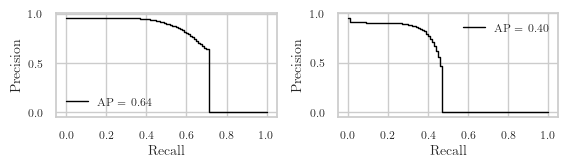

In [10]:
fig_save_dir = '../../thesis/graphics/'

fig, ax = plt.subplots(1, 2, figsize=set_size(width, subplots=(1,2)))
results.plot_pr_curves(iou_thresh=0.5, backend='matplotlib', ax=ax[0], color='black', linewidth=1)
results.plot_pr_curves(iou_thresh=0.95, backend='matplotlib', ax=ax[1], color='black', linewidth=1)
# Set the labels for the legends manually because
# the default ones contain a line for the classes (irrelevant).
ax[0].legend(['AP = 0.64'], frameon=False)
ax[1].legend(['AP = 0.40'], frameon=False)
fig.tight_layout()
fig.savefig(fig_save_dir + 'APpt5-pt95-final.pdf', format='pdf', bbox_inches='tight')

### View dataset in fiftyone <a name="yolofiftyonesession"></a>

We can launch a fiftyone session in a new tab to explore the dataset and the results.

In [ ]:
session = fo.launch_app(yolo_view, auto=False)
session.plots.attach(matrix)
session.open_tab()

In [ ]:
session.close()